In [24]:
from PIL import Image, ImageOps                   # Image Manipulation
from sklearn.decomposition import PCA
import numpy as np                     
import os
import shutil
import matplotlib.pyplot as plt         # Visualization

### Getting the data of an image

In [25]:
def img_data(imgPath):
    orig_img = Image.open(imgPath)
    img_size_kb = os.stat(imgPath).st_size/1024
    ori_pixels = np.array(orig_img.getdata()).reshape(*orig_img.size, -1)
    img_dim = ori_pixels.shape 
    
    
    data_dict = {}
    data_dict['img_size_kb'] = img_size_kb
    data_dict['img_dim'] = img_dim
    
    return data_dict

### Plotting Image with img_data

In [26]:
def plotImgWithData(imgPath):
    data_dict_ori = img_data(imgPath)
    orig_img = Image.open(imgPath)
    
    fig, ax = plt.subplots()
    
    ax.imshow(orig_img)
    size = data_dict_ori['img_size_kb']
    Shape = data_dict_ori['img_dim']
    ax.set_title("Original Image")
    ax.text(1,1200,f'size (kB)  =>  {size}')
    ax.text(1,1260,f'shape      =>  {Shape}')
    
imgPath = 'girl.jpeg'
plotImgWithData(imgPath)

### Applying PCA on Image

In [27]:
def pca_compose(imgPath):
    
    # Read the image
    orig_img = Image.open(imgPath)
    
    # Convert the reading into a 2D numpy array
    img = np.array(orig_img.getdata())
    # Reshape 2D to 3D array 
    
    img = img.reshape(*orig_img.size, -1)
    # Seperate channels from image and using PCA on each channel
    pca_channel = {}
    img_t = np.transpose(img) # transposing the image 
    for i in range(img.shape[-1]):    # For each RGB channel compute the PCA
        
        per_channel = img_t[i] # It will be in a shape (1,1024,1024)
        
        # Converting (1, 1024, 1024) to (1024, 1024)
        channel = img_t[i].reshape(*img.shape[:-1])  
        pca = PCA(random_state = 42)              
        
        fit_pca = pca.fit_transform(channel)        
        
        pca_channel[i] = (pca,fit_pca)  #save PCA models for each channel
#         print(pca, fit_pca.shape)
    return pca_channel

In [28]:
pca_channel = pca_compose(imgPath)

### Checking the variance of each dimension

In [29]:
# Function to tell the percentage of explained variance by n number of components
"""
pca.explained_variance_ratio_ => 


"""

def explained_var_n(pca_channel, n_components):
    var_exp_channel = []; var_exp=0
    
    for channel in pca_channel:
        
        pca,_ = pca_channel[channel]
        
        var_exp_channel.append(np.cumsum(pca.explained_variance_ratio_))
        
        var_exp += var_exp_channel[channel][n_components]
        
    var_exp = var_exp/len(pca_channel)
    
    return var_exp

In [30]:
#We can choose a random number of component to retain
# As we know, our image is of the shape 1024*1024 so maximum number of components can be 0 to 1023.
# So the explained variance in percent is

var_exp = explained_var_n(pca_channel, 1023)

print("Explained variance in percentage by PCA : ", var_exp*100,"%")

Explained variance in percentage by PCA :  99.99999999999997 %


### Plotting variance of every PC 

In [31]:
# Function to plot the individual variance of every principal component
"""
pca.explained_variance_ratio_ => 

"""

def variance_added_pc(pca_channel):
    
    var_exp_channel = [];var_exp=0;
    
    for channel in pca_channel:
        pca,_ = pca_channel[channel]
        var_exp_channel.append(pca.explained_variance_ratio_)
        
#     print(np.array(var_exp_channel).shape)
    var_exp = (var_exp_channel[0]+var_exp_channel[1]+var_exp_channel[2])/3
    
#     print(np.array(var_exp).shape)
    x = list(var_exp);
    y = list(range(1,1+len(x)));
    y = list(range(1,21))
    
    plt.yticks(np.arange(0, max(x)+0.05,0.05))
    plt.xticks(np.arange(min(y), max(y)+1,1))
    plt.title("Individual Variance for each Principal Component")
    plt.ylabel('Variance')
    plt.xlabel('Principal Component');
    plt.bar(y,x[:20],color = 'black')
    plt.grid(True)
    plt.show()

In [32]:
variance_added_pc(pca_channel)

In [33]:
# So even if we select 50 components, the information retention will be huge.
n_components = 50

var_exp = explained_var_n(pca_channel, n_components)

print("Explained variance in percentage by PCA : ", var_exp*100,"%")

Explained variance in percentage by PCA :  97.778657925892 %


In [34]:
# Function to select the desired number of components
"""
pca_channel = {
        PCA(random_state=42) pca_fit.shape = (1024, 1024),
        PCA(random_state=42) pca_fit.shape = (1024, 1024),
        PCA(random_state=42) pca_fit.shape = (1024, 1024),
    }

pca.components_ => It is an array of eigen vectors arranged in decreasing order of variance.
                   These are required to reconstruct the image from the PCs.
                   
To reconstruct the image => we require the dot product of pca.components_ and the PCs + pca.mean_

"""
def pca_transform(pca_channel, n_components):
    temp_res = []
    
    # Looping over all the channels we created from pca_compose function
    for channel in range(len(pca_channel)):
        pca, fit_pca = pca_channel[channel]
        
        # Selecting image pixels across first n components
        pca_pixel = fit_pca[:, :n_components]
        # 1024 , 50
        # First n-components
        pca_comp = pca.components_[:n_components, :]
        # 50 , 1024
        
        # Projecting the selected pixels along the desired n-components (De-standardization)
        compressed_pixel = np.dot(pca_pixel, pca_comp) + pca.mean_
        
        # Stacking channels corresponding to Red Green and Blue
        temp_res.append(compressed_pixel)
        
    # transforming (channel, width, height) to (height, width, channel)
    compressed_image = np.transpose(temp_res)
    
    # Forming the compressed image
    compressed_image = np.array(compressed_image,dtype=np.uint8)
    
    return compressed_image

In [35]:
compressed_image = pca_transform(pca_channel,n_components=n_components)
Image.fromarray(compressed_image).save("compressed_img.jpeg")

# This will save the compressed image

In [36]:

def compareImg(orig_img_path, compressed_img_path):
    
    data_dict_orig = img_data(orig_img_path)
    data_dict_comp = img_data(compressed_img_path)
    
    orig_img = Image.open(orig_img_path)
    comp_img = Image.open(compressed_img_path)
    
    fig, ax = plt.subplots(1, 2)
    
    fig.tight_layout(pad=5.0)
    fig.set_figwidth(15)
    fig.set_figheight(15)
    
    # Original Image
    ax[0].imshow(orig_img)
    orig_size = data_dict_orig['img_size_kb']
    orig_Shape = data_dict_orig['img_dim']
    ax[0].set_title("Original Image")
    ax[0].text(1,orig_Shape[1]+100,f'size (kB)  =>  {orig_size}')
    ax[0].text(1,orig_Shape[1]+150,f'shape      =>  {orig_Shape}')
    
    # Compressed Image
    ax[1].imshow(comp_img)
    comp_size = data_dict_comp['img_size_kb']
    comp_Shape = data_dict_comp['img_dim']
    ax[1].set_title("Compressed Image")
    
    ax[1].text(1,orig_Shape[1]+100,f'size (kB)  =>  {comp_size}')
    ax[1].text(1,orig_Shape[1]+150,f'shape      =>  {comp_Shape}')

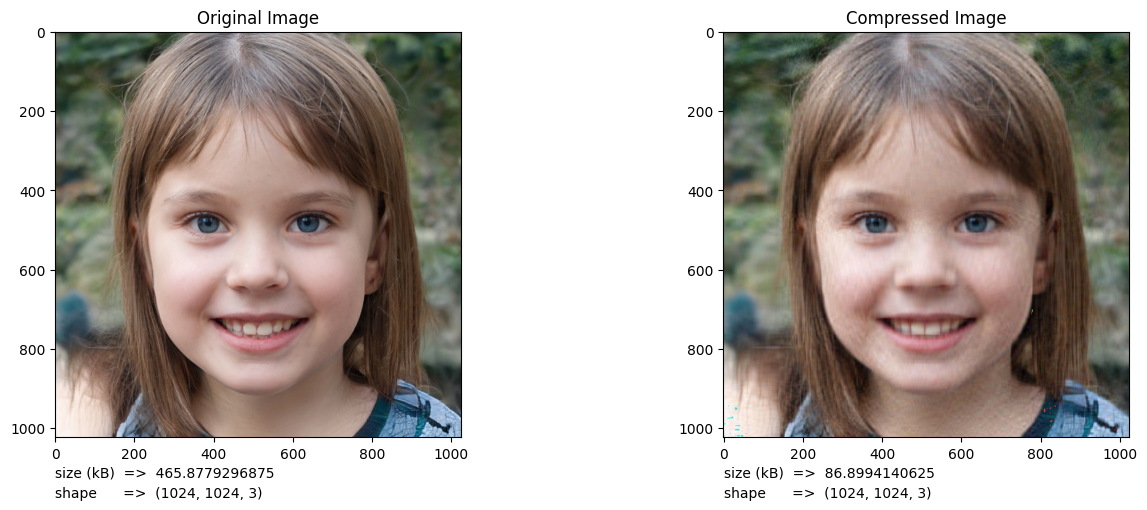

In [37]:
orig_img_path = "girl.jpeg"
compressed_img_path = 'compressed_img.jpeg'

compareImg(orig_img_path, compressed_img_path)

### Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR):
In this code, cv2.imread() is used to read the image files. The MSE is calculated by finding the mean of the squared difference between the pixel values of the original and compressed images. The PSNR is calculated using the cv2.PSNR() function from the OpenCV library.

<b>Mean Squared Error (MSE):</b> This metric measures the average difference between the pixel values in the original image and the compressed image. If the MSE is high, it indicates that the compressed image has lost a significant amount of information.

<b>Peak Signal-to-Noise Ratio (PSNR):</b> This metric measures the ratio between the maximum possible value of the signal and the noise introduced by compression. A low PSNR value indicates that the compressed image has lost a significant amount of information.

In [38]:
import cv2
import numpy as np

def get_mse_psnr(original_image_path, compressed_image_path):
    original = cv2.imread(original_image_path)
    compressed = cv2.imread(compressed_image_path)
    mse = np.mean((original - compressed) ** 2)
    psnr = cv2.PSNR(original, compressed)
    return mse, psnr


In [39]:
orig_img_path = "girl.jpeg"
compressed_img_path = 'compressed_img.jpeg'
get_mse_psnr(orig_img_path, compressed_img_path) 

(31.870715777079266, 30.36736325883778)

### Interpreting PSNR value:
In general, a PSNR value of <font color=red>30 or higher is considered to be indicative of good image quality in image compression.</font> This means that the compressed image has a high level of similarity to the original, uncompressed image. However, it's important to note that the interpretation of PSNR values may depend on the specific application and the context in which they are being used.

For example, in some applications where high levels of image quality are required, a PSNR value of 30 might be considered only satisfactory, and a higher value might be necessary. Conversely, in other applications where image quality is less critical, a PSNR value of 30 might be considered very good. Therefore, it's important to carefully evaluate the PSNR results in the specific context of your application and take into account any other relevant factors, such as file size or computational complexity.

### Structural Similarity Index (SSIM):
In this code, the ssim() function from the skimage.metrics module is used to calculate the structural similarity index between the original and compressed images.
<font color=red><b>A low SSIM value indicates that the compressed image has lost a significant amount of structural information.</b></font>

The range of values for the Structural Similarity Index (SSIM) is between <font color=red><b>-1 and 1.</b></font>

A value of <font color=blue>1 indicates that the two images being compared are identical</font>, while a value of -1 indicates that they are completely dissimilar. A value of 0 indicates that there is no similarity between the two images.

In practice, however, the SSIM values typically range between 0 and 1, where higher values indicate greater similarity between the images. For example, a value of 0.9 indicates a high degree of similarity between the images, while a value of 0.5 indicates a relatively low degree of similarity.

It's worth noting that the interpretation of SSIM values may depend on the specific application and the context in which they are being used. In some cases, a value that might seem low in one context might be considered high in another. Therefore, it's important to carefully evaluate the SSIM results in the specific context of your application.
    

In [40]:
from skimage.metrics import structural_similarity as ssim

def get_ssim(original_image_path, compressed_image_path):
    original = cv2.imread(original_image_path)
    compressed = cv2.imread(compressed_image_path)   
    ssim_value = ssim(original, compressed, multichannel=True, channel_axis=2)
    return ssim_value


In [41]:
orig_img_path = "girl.jpeg"
compressed_img_path = 'compressed_img.jpeg'
get_ssim(orig_img_path, compressed_img_path)

0.8142219585113563

### Note:
It's important to note that these metrics may not always provide a clear indication of whether an image has been compressed, as some compression techniques may be designed to preserve certain aspects of the image while sacrificing others. Additionally, some image formats such as JPEG inherently use lossy compression, so it may be difficult to determine whether an image has been compressed by looking at metrics alone.

### Displaying dataset

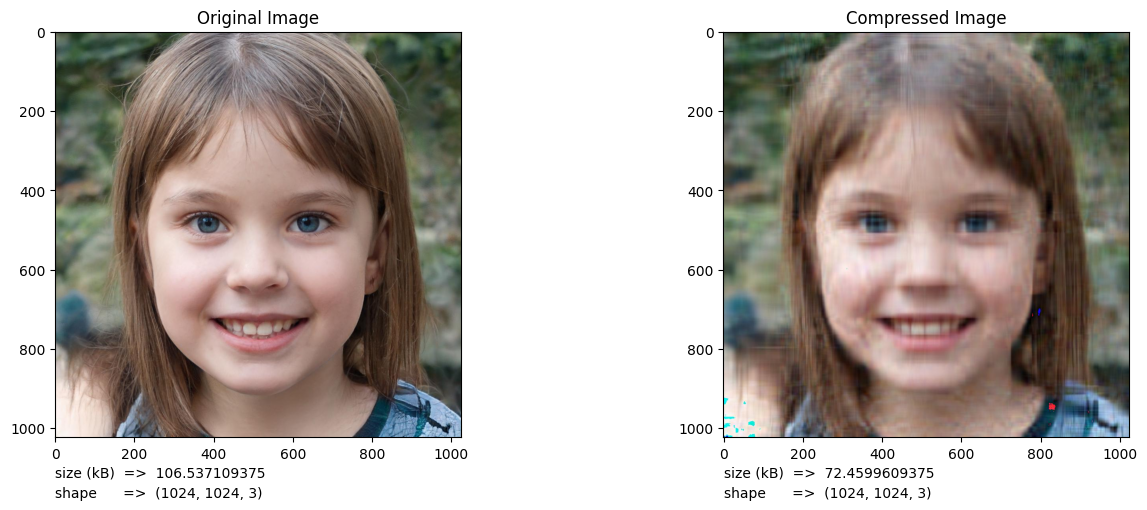

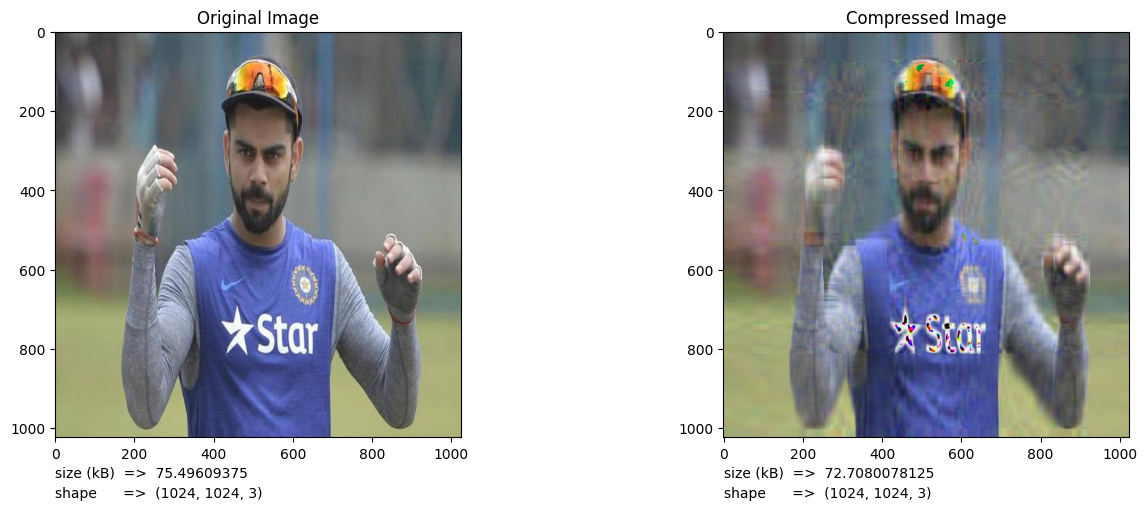

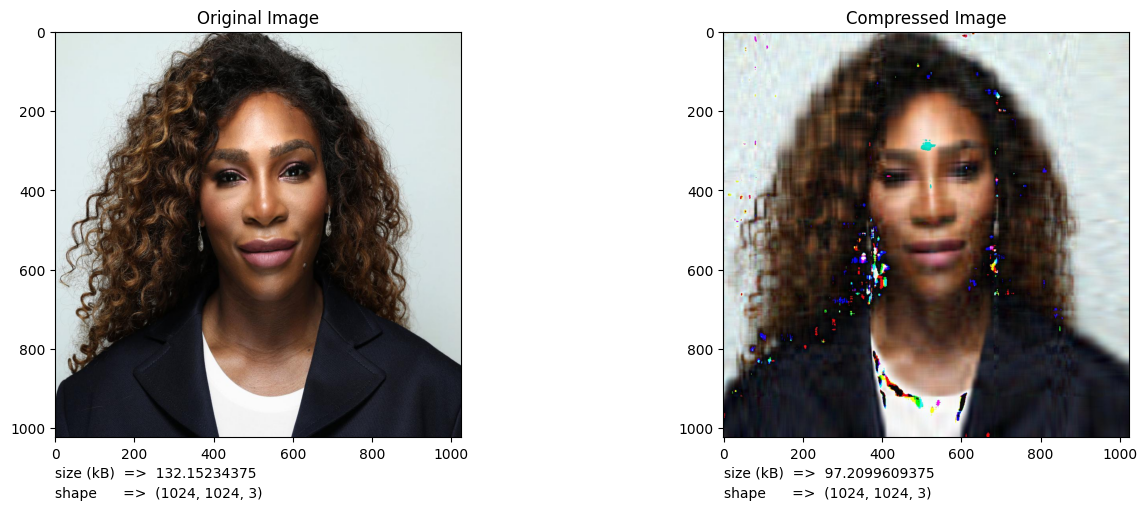

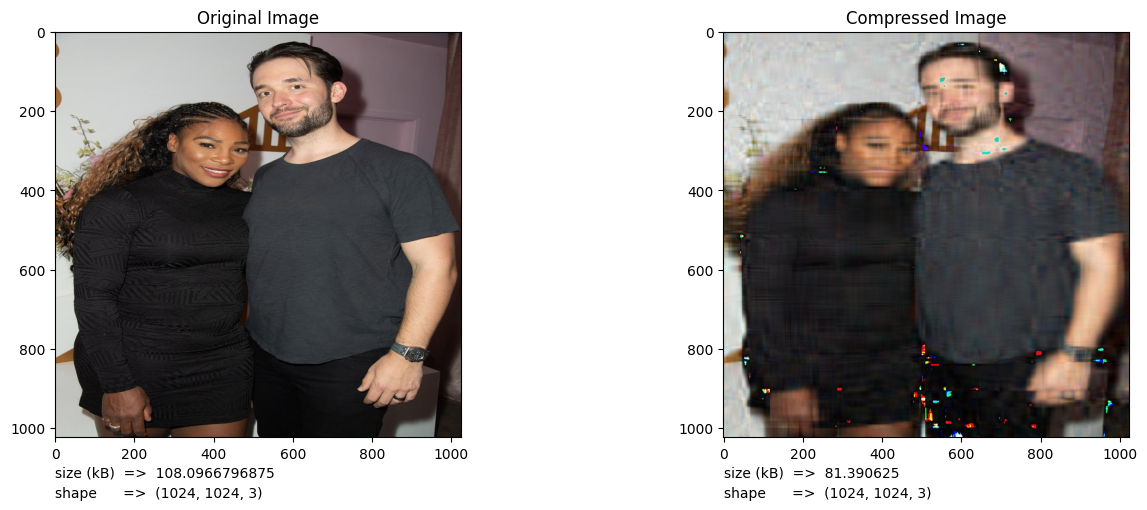

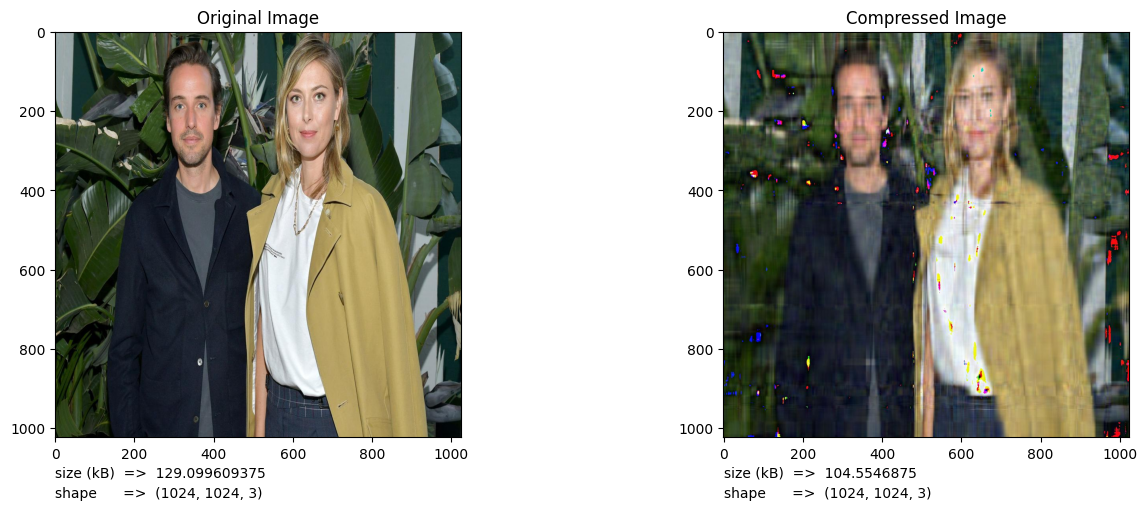

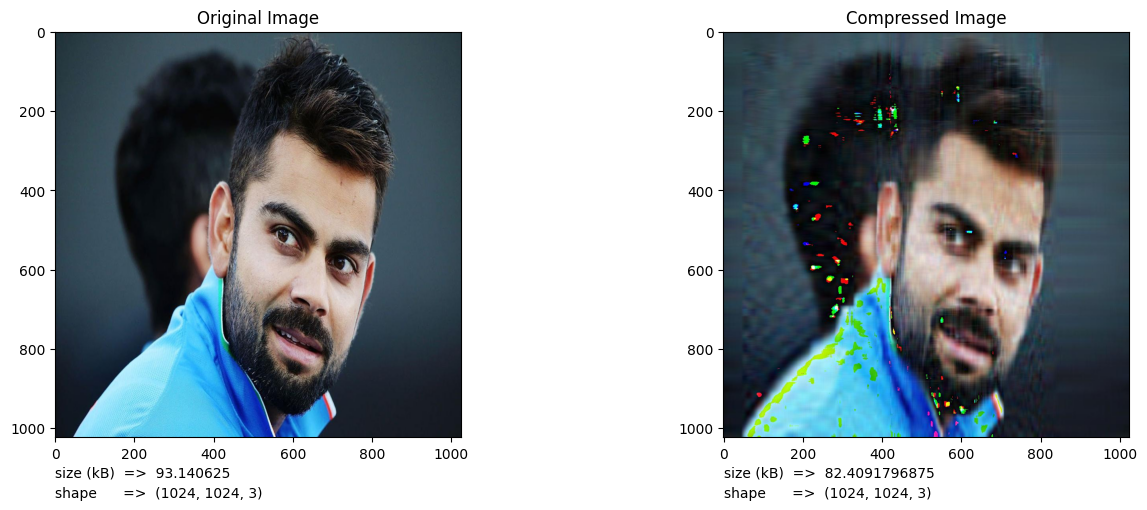

In [42]:
test_image_dir = './data/'
resized_test_image_dir = './resized_data/'
destination_image_dir = './compressed/'
count = 0;

def prepareDataset(test_image_dir) :
    
    if os.path.exists(resized_test_image_dir):
        shutil.rmtree(resized_test_image_dir)
    os.mkdir(resized_test_image_dir)
    
    if os.path.exists(destination_image_dir):
            shutil.rmtree(destination_image_dir)
    os.mkdir(destination_image_dir)
    
    for entry in os.scandir(test_image_dir):
        orig_img_path  = entry.path
        extension = entry.path.split('.')[-1];
        image_name = entry.path.split('/')[-1].split('.')[0];
        img = Image.open(orig_img_path)
        (w, h) = img.size
        if((w,h) != (1024, 1024)):
            img = img.resize((1024, 1024))
        img.save(f'./resized_data/{image_name}.{extension}')
            

prepareDataset(test_image_dir)
n_components = 22

for entry in os.scandir(resized_test_image_dir):
    orig_img_path  = entry.path
    
    extension = entry.path.split('.')[-1];
    image_name = entry.path.split('/')[-1].split('.')[0];
    compressed_img_path = f'{destination_image_dir}{image_name}.{extension}'
    
    dictionary = img_data(orig_img_path)
    
    pca_channels = pca_compose(orig_img_path)
    compressed_image = pca_transform(pca_channels, n_components)
    
    Image.fromarray(compressed_image).save(compressed_img_path)
    
    compareImg(orig_img_path, compressed_img_path)
    


### Getting Metric Values for above data

In [43]:
orig_image_dir = './resized_data/'
compressed_image_dir = './compressed/'




def get_report(orig_image_dir, compressed_image_dir):
    ssim_values = []
    psnr_values = []
    mse_values = []
    images_names = []
    for entry in os.scandir(orig_image_dir):
        orig_img_path = entry.path
        images_names.append(entry.name)
        extension = entry.path.split('.')[-1]
        image_name = entry.path.split('/')[-1].split('.')[0]
        compressed_img_path = f'{compressed_image_dir}{image_name}.{extension}'
        ssim_values.append(get_ssim(orig_img_path, compressed_img_path))
        
        (a,b) = get_mse_psnr(orig_img_path, compressed_img_path)
        psnr_values.append(b)
        mse_values.append(a)
    return (mse_values, psnr_values, ssim_values, images_names)

mse_values, psnr_values, ssim_values, images_names = get_report(orig_image_dir, compressed_image_dir)
print(mse_values)

[30.45377477010091, 48.88848400115967, 36.73802248636881, 55.03696918487549, 45.04612763722738, 60.3574021657308, 42.19481245676676]


### Plotting values 

C:\Users\Shivcharan\AppData\Local\Temp\ipykernel_29612\1935686322.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


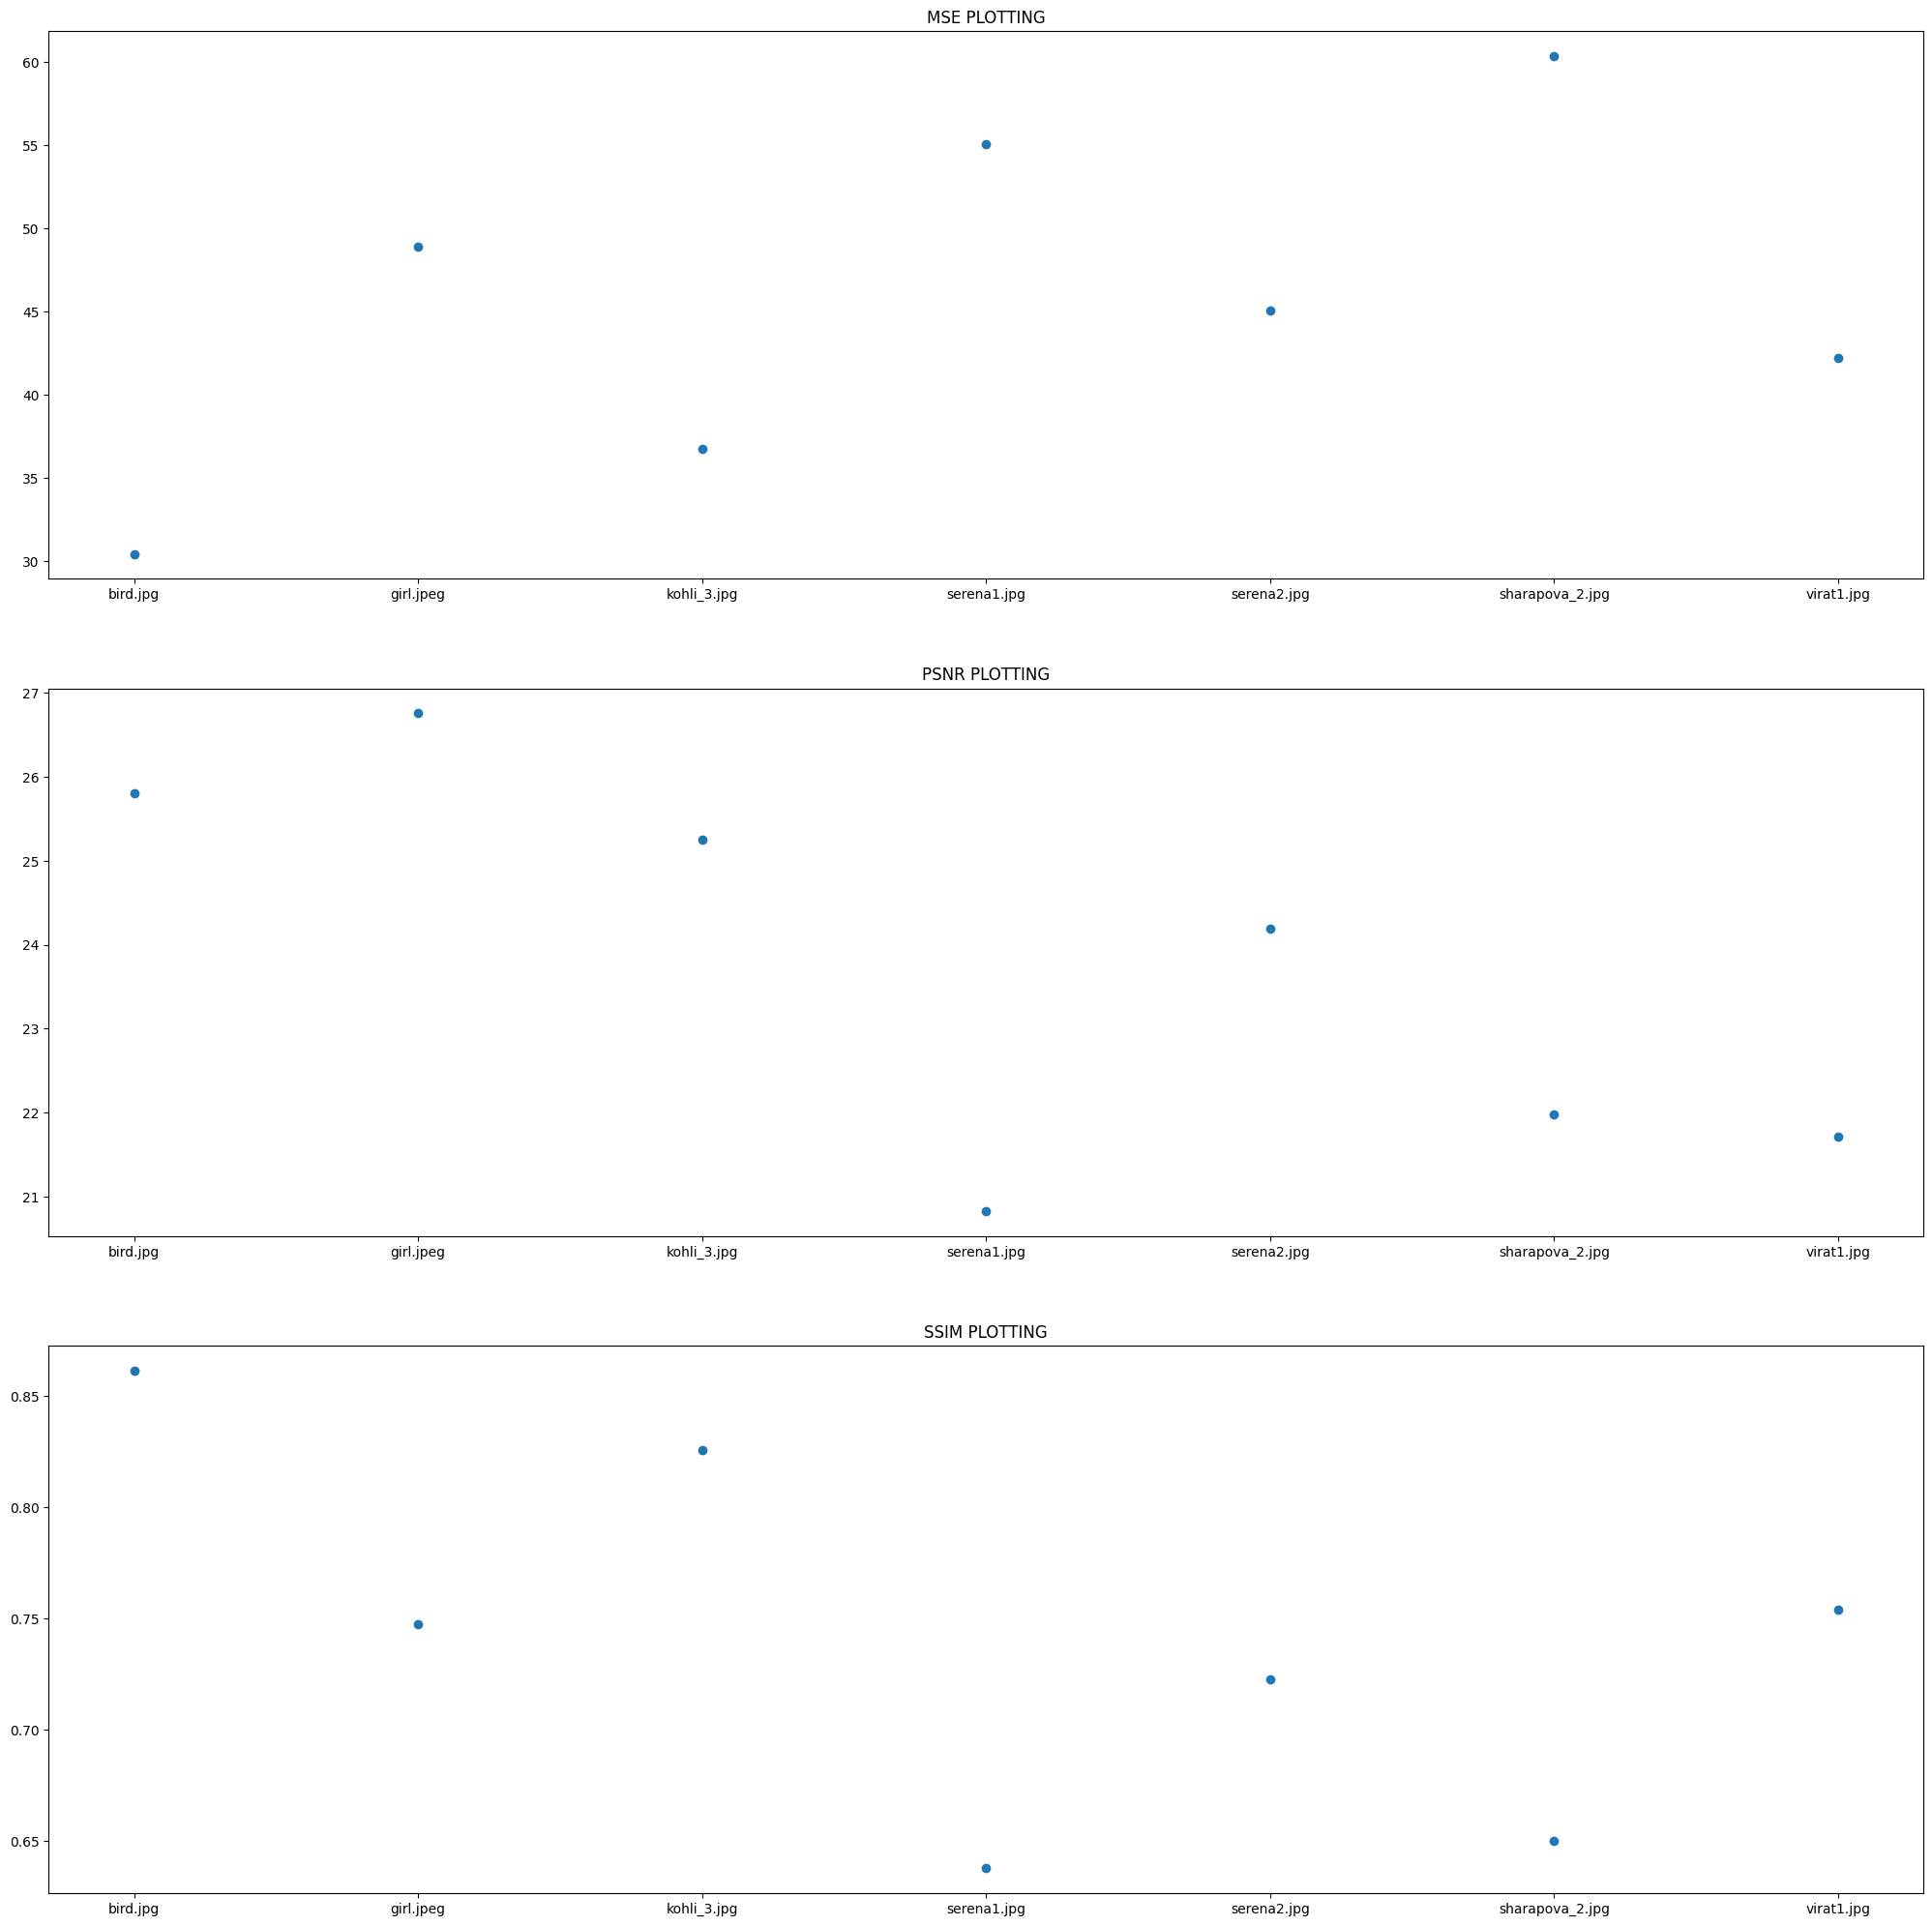

In [44]:
def plot_metrices():
    fig, ax = plt.subplots(3, 1)
    
#     fig.tight_layout(pad=1.0)
    fig.set_figwidth(25)
    fig.set_figheight(25)
    
#     MSE 
    ax[0].scatter(images_names, mse_values)
    ax[0].set_title("MSE PLOTTING")
    
#     PSNR
    ax[1].scatter(images_names,psnr_values)
    ax[1].set_title("PSNR PLOTTING")
    
#     SSIM
    ax[2].scatter(images_names,ssim_values)
    ax[2].set_title("SSIM PLOTTING")
    fig.show()
    
plot_metrices()